# **Transfer learning based damage road detection for multiple countries**

## Task :

1. Object Detection and classification.
2. Fine tune pretrained models to our dataset.

Link for referenence for training models:

https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html

In [ ]:
import os
from xml.etree import ElementTree
from bs4 import BeautifulSoup
import seaborn as sns
import collections
import pandas as pd
import xml.etree.ElementTree as ET
import cv2 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import shutil
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imgaug as ia
import imageio
import re
import numpy as np


In [ ]:
!wget --header="Host: doc-0k-98-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.198 Safari/537.36 Edg/86.0.622.69" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_ne0kvt0qd6os8a3ml789ao3v98s9j6ko_nonce=9p2bkiq3qrr9g" --header="Connection: keep-alive" "https://doc-0k-98-docs.googleusercontent.com/docs/securesc/0ett1sjns8i7cuptvjmi6sd76v2m5kng/9ovvrj3k1lbp5opgdc4b9ogi6n6ubo4g/1605880125000/08318906962772725564/08318906962772725564/11hgvhw5k0MxwCFbdhsmLu4rHvdR6qxmT?e=download&authuser=0&nonce=9p2bkiq3qrr9g&user=08318906962772725564&hash=ld145t6iqiskmvatv0m4m90kvh02r1l2" -c -O 'train.tar'

--2020-11-22 14:20:22--  https://doc-0k-98-docs.googleusercontent.com/docs/securesc/0ett1sjns8i7cuptvjmi6sd76v2m5kng/9ovvrj3k1lbp5opgdc4b9ogi6n6ubo4g/1605880125000/08318906962772725564/08318906962772725564/11hgvhw5k0MxwCFbdhsmLu4rHvdR6qxmT?e=download&authuser=0&nonce=9p2bkiq3qrr9g&user=08318906962772725564&hash=ld145t6iqiskmvatv0m4m90kvh02r1l2
Resolving doc-0k-98-docs.googleusercontent.com (doc-0k-98-docs.googleusercontent.com)... 172.217.15.65, 2607:f8b0:4004:810::2001
Connecting to doc-0k-98-docs.googleusercontent.com (doc-0k-98-docs.googleusercontent.com)|172.217.15.65|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2020-11-22 14:20:22 ERROR 403: Forbidden.



In [ ]:
#untar train data
!tar -xvf /content/drive/MyDrive/object_detection/train.tar

Streaming output truncated to the last 5000 lines.
train/Japan/annotations/xmls/Japan_009766.xml
train/Japan/annotations/xmls/Japan_006254.xml
train/Japan/annotations/xmls/Japan_008726.xml
train/Japan/annotations/xmls/Japan_004664.xml
train/Japan/annotations/xmls/Japan_007945.xml
train/Japan/annotations/xmls/Japan_006391.xml
train/Japan/annotations/xmls/Japan_005903.xml
train/Japan/annotations/xmls/Japan_008200.xml
train/Japan/annotations/xmls/Japan_003663.xml
train/Japan/annotations/xmls/Japan_001949.xml
train/Japan/annotations/xmls/Japan_011141.xml
train/Japan/annotations/xmls/Japan_003141.xml
train/Japan/annotations/xmls/Japan_002870.xml
train/Japan/annotations/xmls/Japan_008094.xml
train/Japan/annotations/xmls/Japan_007381.xml
train/Japan/annotations/xmls/Japan_012963.xml
train/Japan/annotations/xmls/Japan_007843.xml
train/Japan/annotations/xmls/Japan_004889.xml
train/Japan/annotations/xmls/Japan_011099.xml
train/Japan/annotations/xmls/Japan_003745.xml
train/Japan/annotations/xmls/

after unzipping:

we get following folders




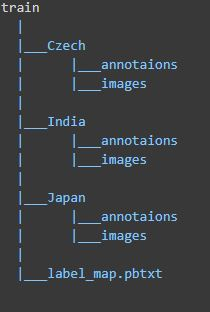



       


We can see We have data for three countries namely **Czech**,**India** and **Japan**.

In each country folder we have annotation folder and images folder.

**annotation folder** contains xml filesin PASCAL VOC format. We will see what exactly data xml file have.

**image folder** contains images in jpg format.

label_map.pbtxt file have labels with thier id's. We will see that as well

## First look at Xml file

In [ ]:
%cd /content
!rm -rf /content/data

/content


In [ ]:
#We will check content in .xml file given for image 


with open('/content/train/Czech/annotations/xmls/Czech_000010.xml', 'r') as f: 
    data = f.read()

Bs_data = BeautifulSoup(data, "xml") 
Bs_data

<?xml version="1.0" encoding="utf-8"?>
<annotation>
<folder>images</folder>
<filename>Czech_000010.jpg</filename>
<size>
<depth>3</depth>
<width>600</width>
<height>600</height>
</size>
<object>
<name>D40</name>
<bndbox>
<xmin>213</xmin>
<ymin>409</ymin>
<xmax>274</xmax>
<ymax>441</ymax>
</bndbox>
</object>
<object>
<name>D10</name>
<bndbox>
<xmin>228</xmin>
<ymin>473</ymin>
<xmax>327</xmax>
<ymax>495</ymax>
</bndbox>
</object>
</annotation>

From xml file we can see following thing
1. Image name
2. image size
3. object with x,y axis dimension 
4. In single image we can have multiple objects that we have to class.

## Now we will see total images including all countries and labels

In [ ]:
# the number of total images and total labels.
country = ['Czech','India','Japan']
base_path = os.getcwd() + '/train/'
cls_names = []
total_images = 0
for cont in country:
    
    file_list = [filename for filename in os.listdir(base_path + cont + '/annotations/xmls/')]

    for file in file_list:

        total_images = total_images + 1
      
        infile_xml = open(base_path + cont + '/annotations/xmls/' +file)
        tree = ElementTree.parse(infile_xml)
        root = tree.getroot()
        for obj in root.iter('object'):
            cls_name = obj.find('name').text
            cls_names.append(cls_name)

print("Total number of images：" + str(total_images))
print("Total number of labels：" + str(len(cls_names)))

Total number of images：21041
Total number of labels：34702


In [ ]:
#check classes
damageTypes=list(set(cls_names))
print(damageTypes)
print('number of classes: ', len(damageTypes))

['D10', 'D0w0', 'D43', 'D40', 'D01', 'D11', 'D50', 'D20', 'D44', 'D00']
number of classes:  10


So, We have total 10 classes.

Now we will see distribution of these classes

D10 : 4446
D0w0 : 1
D43 : 793
D40 : 5627
D01 : 179
D11 : 45
D50 : 3581
D20 : 8381
D44 : 5057
D00 : 6592


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of classes')

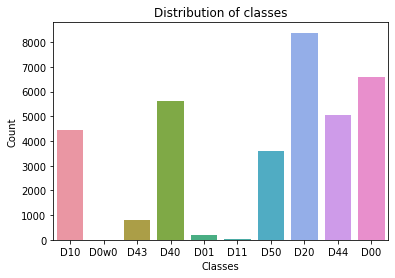

In [ ]:
# We will see Classes distribution for whole data
count_dict = collections.Counter(cls_names)
cls_count = []
for damageType in damageTypes:
    print(str(damageType) + ' : ' + str(count_dict[damageType]))
    cls_count.append(count_dict[damageType])
    
sns.set_palette("winter", 8)
sns.barplot(damageTypes, cls_count)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of classes')

We can see from above distribution that classes are not balance.

D0w0, D11, D01 and D43 are very rare classes.

Now we will see countriwise images count and label count

In [ ]:

# the number of each class labels for each country
for gov in country:
    cls_names = []
    total_images = 0
    file_list = [filename for filename in os.listdir(base_path + gov + '/annotations/xmls/')]

    for file in file_list:

        total_images = total_images + 1
      
        infile_xml = open(base_path + gov + '/annotations/xmls/' +file)
        tree = ElementTree.parse(infile_xml)
        root = tree.getroot()
        for obj in root.iter('object'):
          cls_name = obj.find('name').text
          cls_names.append(cls_name)
    print('Country : ',gov)
    print("\nTotal images in {} ： {}".format(gov , total_images))
    print("Total labels in {} ： {}\n".format(gov , len(cls_names)))
    
    count_dict = collections.Counter(cls_names)
    cls_count = []
    for damageType in damageTypes:
        print(str(damageType) + ' : ' + str(count_dict[damageType]))
        cls_count.append(count_dict[damageType])
    print('***************************************************************************************\n')


Country :  Czech

Total images in Czech ： 2829
Total labels in Czech ： 1745

D10 : 399
D0w0 : 0
D43 : 0
D40 : 197
D01 : 0
D11 : 0
D50 : 0
D20 : 161
D44 : 0
D00 : 988
***************************************************************************************

Country :  India

Total images in India ： 7706
Total labels in India ： 8203

D10 : 68
D0w0 : 1
D43 : 57
D40 : 3187
D01 : 179
D11 : 45
D50 : 28
D20 : 2021
D44 : 1062
D00 : 1555
***************************************************************************************

Country :  Japan

Total images in Japan ： 10506
Total labels in Japan ： 24754

D10 : 3979
D0w0 : 0
D43 : 736
D40 : 2243
D01 : 0
D11 : 0
D50 : 3553
D20 : 6199
D44 : 3995
D00 : 4049
***************************************************************************************



1. Czech country have only four classes (label)
2. India have all classes (10 classes)
3. Japan have 7 classes.

So we can say that only india contains all classes. Also in india we have class 'D0w0' occurs only once. We can remove that or wil not include while training.

Japan have more numbere of images compare to Czech and India.

So we have more versetile data.

### We will create two folder that will contain all the images and annotations file.

In [ ]:
! mkdir '/content/data'

In [ ]:
! mkdir '/content/data/Images'

base_path = '/content/train/'
for cont in country:
  for fil in os.listdir(base_path + cont + '/images/'):
    shutil.copy(base_path + cont + '/images/'+ fil, "/content/data/Images") 
file_list = [filename for filename in os.listdir('/content/data/Images')]
print('Total images in Image folder  : ',len(file_list))

Total images in Image folder  :  21041


In [ ]:
! mkdir '/content/data/Annotations'

base_path = '/content/train/'
for cont in country:
  for fil in os.listdir(base_path + cont + '/annotations/xmls'):
    shutil.copy(base_path + cont + '/annotations/xmls/'+ fil, "/content/data/Annotations") 

file_list = [filename for filename in os.listdir('/content/data/Annotations')]
print('Total images in Annotation folder  : ',len(file_list))

Total images in Annotation folder  :  21041


## Convert xml to csv 

In [ ]:

def xml_to_csv(base_path):
    xml_list = []
    file_list = [filename for filename in os.listdir(base_path)]
    for file in file_list:
          infile_xml = open('/content/data/Annotations/' + file.split('.')[0] + '.xml')
          #print(base_path + gov + '/annotations/xmls/' + file)
          tree = ElementTree.parse(infile_xml)
          root = tree.getroot()
          for obj in root.findall('object'):
              value = (str(root.find('filename').text),
                       int(root.find('size').find('width').text),
                       int(root.find('size').find('height').text),
                       obj.find('name').text,
                       int(obj.find('bndbox').find('xmin').text),
                       int(obj.find('bndbox').find('ymin').text),
                       int(obj.find('bndbox').find('xmax').text),
                       int(obj.find('bndbox').find('ymax').text))
              xml_list.append(value)
    column_name = ['filename', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


base_path =  '/content/data/Images'
labels_df = xml_to_csv(base_path)
labels_df.head(10)

,filename,width,height,label,xmin,ymin,xmax,ymax
0,India_002925.jpg,720,720,D00,23,341,228,639
1,India_002925.jpg,720,720,D00,568,457,668,618
2,India_002925.jpg,720,720,D40,648,504,714,576
3,Japan_002084.jpg,600,600,D20,422,414,597,563
4,Japan_002084.jpg,600,600,D10,389,366,440,381
5,India_008395.jpg,720,720,D40,489,452,554,489
6,India_008395.jpg,720,720,D40,619,523,720,580
7,India_008395.jpg,720,720,D20,351,509,581,626
8,Japan_006397.jpg,600,600,D43,5,441,600,597
9,India_005365.jpg,720,720,D00,154,483,211,530


In [ ]:
labels_df.shape

(34702, 8)

In [ ]:
image_with_label = list(set(labels_df.filename.values))

print('Number of images have labels : ', len(image_with_label))

Number of images have labels :  14569


In [ ]:
img_list = [filename for filename in os.listdir('/content/data/Images')]
annot_list = [filename for filename in os.listdir('/content/data/Annotations')]

### Plotting images with labels and bounding box

In [ ]:
def plot_image (img_file):
  gov = img_file.split('.')[0]
  image = cv2.imread('/content/data/Images/' + gov + '.jpg')
  image1 = cv2.imread('/content/data/Images/' + gov + '.jpg')

  infile_xml = open('/content/data/Annotations/' + gov + '.xml')
  tree = ElementTree.parse(infile_xml)
  root = tree.getroot()
    
  for obj in root.iter('object'):
        cls_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        xmin = int(xmlbox.find('xmin').text)
        xmax = int(xmlbox.find('xmax').text)
        ymin = int(xmlbox.find('ymin').text)
        ymax = int(xmlbox.find('ymax').text)

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        image1 = cv2.putText(image1,cls_name,(xmin,ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)

        # draw bounding box
        image1 = cv2.rectangle(image1, (xmin, ymin), (xmax, ymax), (0,255,0),3)
  plt.figure(figsize=(15,15))
  plt.axis('off')
  plt.subplot(121)
  plt.title('original image')
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.subplot(122)
  plt.title('With label and bounding box')
  plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
  plt.show()
  
image_with_label = list(set(labels_df.filename.values))
for i in range(0,15):
  plot_image(image_with_label [i])

### Potting some images and images with bounding box with class  from csv file

In [ ]:
def show_image_objects(image_row):
  base_path = '/content/data/Images/'
  img_path = '/content/data/Images/' + image_row.filename

  lable = image_row.label
  image = cv2.imread(img_path)
  image1 =  cv2.imread(img_path)
  #draw = image.copy()
  #draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
  font = cv2.FONT_HERSHEY_SIMPLEX
  image1 = cv2.putText(image1,lable,(image_row.xmin,image_row.ymin-10),font,1,(0,255,0),2,cv2.LINE_AA)
  image1 = cv2.rectangle(image1, (image_row.xmin,image_row.ymin), (image_row.xmax, image_row.ymax), (0,255,0),3)
  #draw_box(draw, box, color=(255, 255, 0))
  plt.figure(figsize=(15,15))
  plt.axis('off')
  plt.subplot(121)
  plt.title('original image')
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.subplot(122)
  plt.title('With label and bounding box')
  plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
  plt.show()
    
#display 20 images and with their mask
for i in range(0,20):
  show_image_objects(labels_df.iloc[i])

In [ ]:
# we will remove 'D0w0' class from csv file we will not use that in training model 

print(labels_df[labels_df['label'] == 'D0w0'])
labels_df_copy = labels_df.copy()
labels_df_copy = labels_df.drop(labels_df[labels_df['label'] == 'D0w0'].index)
print(labels_df_copy.shape)

              filename  width  height label  xmin  ymin  xmax  ymax
9417  India_006389.jpg    720     720  D0w0   455   490   570   663
(34701, 8)


In [ ]:
! rm '/content/data/Images/India_006389.jpg'

India_006389.jpg this image has only one class 'D0w0' so we will remove from our /content/data/Images dir.

In [ ]:
# train - test split 

X_train,X_test = train_test_split(labels_df_copy, test_size=0.2, random_state=42)

print('shape of total data : ',labels_df_copy.shape)
print('shape of train label  : ',X_train.shape)
print('shape of test label : ',X_test.shape)

shape of total data :  (34701, 8)
shape of train label  :  (27760, 8)
shape of test label :  (6941, 8)


In [ ]:
#saving this into csv file for modeling purpose
! mkdir '/content/data/label_csv'
X_train.to_csv('/content/data/label_csv/train_label.csv',index=False)
X_test.to_csv('/content/data/label_csv/test_label.csv',index = False)
labels_df_copy.to_csv('/content/data/label_csv/labels_df.csv',index = False)

### Now we will Look into label_map.pbtxt file 

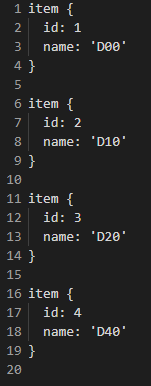

so label_map.pbtxt file has labels with their id .But they given omly 4 labels.
But we have 9 labels so we will edit and modify that file then save in data folder.

item {
  id: 1
  name: 'D00'
}

item {
  id: 2
  name: 'D10'
}

item {
  id: 3
  name: 'D20'
}

item {
  id: 4
  name: 'D40'
}

item {
  id: 5
  name: 'D11'
}

item {
  id: 6
  name: 'D43'
}

item {
  id: 7
  name: 'D44'
}

item {
  id: 8
  name: 'D01'
}

item {
  id: 9
  name: 'D50'
}

In [ ]:
shutil.copy('/content/label_map.pbtxt','/content/data/')

'/content/data/label_map.pbtxt'

After all that we have new folder 'data' that structure is :

data
  |
  |___Annotation
  |
  |___Images
  |
  |___label_csv
  |
  |___label_map.pbtxt


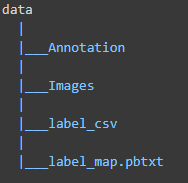


Annotation folder  have all annotation files

Images folder have all the images

label_csv folder have train and test labels csv files

label_map.pbtxt is modified file.

# Observation :

1. We have to total 21041 images and their corresponding xml files

2. We have total 10 classes. In which 'D0w0' is occure only once in Indian dataset. So we can remove that.

3. We have 14569 images that has label.Some of the images have multiple labels.

4. After we convert xml file into csv file the we observe that multiple labeled image has repetaed like 
  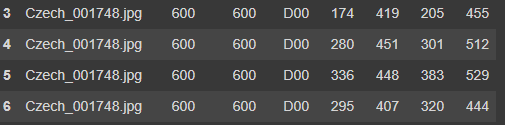


here image is repeated with different lebels . So we may lead to data leakage problem because these repeated images with different labels might go into test data .So we need to tackle this problem.
One thing we can do is split all images randomly  into train and test (We will make two folder).Then we will creat xm to csvfile for train and test set.


5. In label_map.pbtxt have map for only 4 labels so we modified that according 9 classes (D0w0 class is removed)



### Avoiding Data leakage:

In [ ]:
image_with_label = list(set(labels_df_copy.filename.values))

print('Number of images have labels : ', len(image_with_label))

Number of images have labels :  14568


In [ ]:
import random

# creat list of images randomly sample from images that have object
#Since we have ony 14568 images that have labels So we will randomly select from them (80% for train)
train_img = random.sample(image_with_label,k = int(0.8*len(image_with_label)))

In [ ]:
#we creat test set 
test_img = list(set(image_with_label) - set(train_img))

In [ ]:
print('Total images for train : ', len(train_img))
print('Total images for test : ',len(test_img))

Total images for train :  11654
Total images for test :  2914


## Create seperate folder for train and test images in data dir

In [ ]:
! mkdir '/content/data/train_images'

for fil in train_img:
    shutil.copy( '/content/data/Images/'+ fil, "/content/data/train_images")

file_list = [filename for filename in os.listdir('/content/data/train_images')]
print('Total train images in train_images folder  : ',len(file_list)) 

Total train images in train_images folder  :  11654


In [ ]:
! mkdir '/content/data/test_images'

for fil in test_img:
    shutil.copy( '/content/data/Images/'+ fil, "/content/data/test_images")

file_list = [filename for filename in os.listdir('/content/data/test_images')]
print('Total train images in train_images folder  : ',len(file_list)) 

Total train images in train_images folder  :  2914


In [ ]:
! mkdir '/content/data/train_annotations'

for fil in train_img:
    shutil.copy( '/content/data/Annotations/'+ fil.split('.')[0] + '.xml', "/content/data/train_annotations")

file_list = [filename for filename in os.listdir('/content/data/train_annotations')]
print('Total train images in train_images folder  : ',len(file_list))

Total train images in train_images folder  :  11654


In [ ]:
! mkdir '/content/data/test_annotations'

for fil in test_img:
    shutil.copy( '/content/data/Annotations/'+ fil.split('.')[0] + '.xml', "/content/data/test_annotations")

file_list = [filename for filename in os.listdir('/content/data/test_annotations')]
print('Total train images in test_annotations folder  : ',len(file_list))

Total train images in test_annotations folder  :  2914


## Convert train and test annotation files xml to csv

In [ ]:
# xml to csv for train set
base_path =  '/content/data/train_images'
train_label_df = xml_to_csv(base_path)

train_label_df.head(10)

,filename,width,height,label,xmin,ymin,xmax,ymax
0,India_002925.jpg,720,720,D00,23,341,228,639
1,India_002925.jpg,720,720,D00,568,457,668,618
2,India_002925.jpg,720,720,D40,648,504,714,576
3,Japan_002084.jpg,600,600,D20,422,414,597,563
4,Japan_002084.jpg,600,600,D10,389,366,440,381
5,India_008395.jpg,720,720,D40,489,452,554,489
6,India_008395.jpg,720,720,D40,619,523,720,580
7,India_008395.jpg,720,720,D20,351,509,581,626
8,Japan_006397.jpg,600,600,D43,5,441,600,597
9,India_005365.jpg,720,720,D00,154,483,211,530


In [ ]:
#xml to csv for test set
base_path =  '/content/data/test_images'
test_label_df = xml_to_csv(base_path)

test_label_df.head(10)

,filename,width,height,label,xmin,ymin,xmax,ymax
0,Japan_006013.jpg,600,600,D20,71,455,600,600
1,Japan_006013.jpg,600,600,D10,35,385,122,424
2,Japan_006013.jpg,600,600,D10,93,381,199,403
3,Japan_009051.jpg,600,600,D44,302,365,312,405
4,Japan_009051.jpg,600,600,D44,295,438,327,597
5,India_009132.jpg,720,720,D20,161,493,618,618
6,Japan_002321.jpg,600,600,D43,4,358,600,562
7,Japan_002321.jpg,600,600,D00,294,323,317,399
8,Japan_013132.jpg,600,600,D00,542,275,600,336
9,Japan_013132.jpg,600,600,D43,189,82,410,115


In [ ]:
#cross checking 
print('Total labels in train + test : ',train_label_df.shape[0]+test_label_df.shape[0])

Total labels in train + test :  34701


### Train Classes Distribution:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of classes')

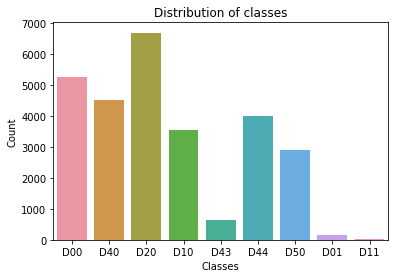

In [ ]:
count_dict = collections.Counter(train_label_df.label)
classes = list(count_dict.keys()) 
count = []
for label in classes:
  count.append(count_dict[label])

sns.set_palette("winter", 8)
sns.barplot(classes,count)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of classes')

### Test Classes Distribution:

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of classes')

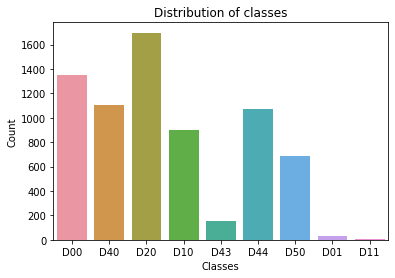

In [ ]:
count_dict = collections.Counter(test_label_df.label)

count = []
for label in classes:
  count.append(count_dict[label])

sns.set_palette("winter", 8)
sns.barplot(classes,count)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of classes')

Both Distribution are almost same. So we can say we sampled data in startify manner.

In [ ]:

test_label_df.to_csv('/content/data/label_csv/test_label.csv',index = False)
train_label_df.to_csv('/content/data/label_csv/train_label.csv',index = False)

In [ ]:
!rm -rf /content/data/Images
!rm -rf /content/data/Annotations


!mkdir /content/data/Images
!mkdir /content/data/Annotations


!cp -r '/content/data/train_images' "/content/data/Images"
!cp -r '/content/data/test_images' "/content/data/Images"

!cp -r '/content/data/train_annotations' '/content/data/Annotations'
!cp -r '/content/data/test_annotations' '/content/data/Annotations'

!rm -rf /content/data/train_images
!rm -rf /content/data/test_images

!rm -rf /content/data/train_annotations
!rm -rf /content/data/test_annotations

My final data folder looks like : 


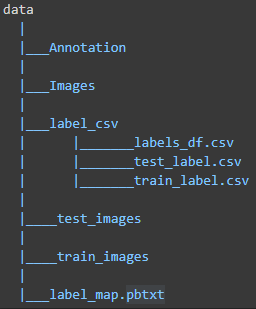

In [ ]:
#!zip -r /content/data.zip /content/data

In [ ]:
'''
!mkdir '/content/data/yolo_files'

def xml_to_yolo_train(xml_file_path,image_path,dest_file,class_name_path):
  unique_class_names = []
  file_list = [filename for filename in os.listdir(xml_file_path)]
  with open(dest_file ,'w') as file:
    for xml_file in file_list:
      infile_xml = open(xml_file_path+'/'+xml_file )
      tree = ElementTree.parse(infile_xml)
      root = tree.getroot()
      image_name = str(root.find('filename').text)
      img_path = image_path +'/'+ image_name
      for obj in root.findall('object'):
        class_name = str(obj.find('name').text)
        #print(class_name)
        if class_name not in  unique_class_names:
           unique_class_names.append(class_name)
        cls_id = unique_class_names.index(class_name)
        x_min = str(int(obj.find('bndbox').find('xmin').text))
        y_min = str(int(obj.find('bndbox').find('ymin').text))
        x_max = str(int(obj.find('bndbox').find('xmax').text))
        y_max = str(int(obj.find('bndbox').find('ymax').text))

        obj = x_min+','+y_min+','+x_max+','+y_max+','+str(cls_id)
        img_path += ' '+ obj
      #print(img_path)
      file.write(img_path+'\n')
      #print(unique_class_names)
  with open(class_name_path,'w') as file:
    for name in unique_class_names:
      file.write(str(name)+'\n')
  return unique_class_names

class_name_path = '/content/data/yolo_files/class_names.txt'
dest_file  = '/content/data/yolo_files/train_yolo.txt'
xml_file_path = '/content/data/train_annotations'
image_path = '/content/data/train_images'
classes = xml_to_yolo_train(xml_file_path,image_path,dest_file,class_name_path)
print('classes : ',classes)
'''

In [ ]:
'''
def xml_to_yolo_test(xml_file_path,image_path,dest_file,classes):
  unique_class_names = classes
  file_list = [filename for filename in os.listdir(xml_file_path)]
  with open(dest_file ,'w') as file:
    for xml_file in file_list:
      infile_xml = open(xml_file_path+'/'+xml_file )
      tree = ElementTree.parse(infile_xml)
      root = tree.getroot()
      image_name = str(root.find('filename').text)
      img_path = image_path +'/'+ image_name
      for obj in root.findall('object'):
        class_name = str(obj.find('name').text)
        #print(class_name)
        if class_name not in  unique_class_names:
           unique_class_names.append(class_name)
        cls_id = unique_class_names.index(class_name)
        x_min = str(int(obj.find('bndbox').find('xmin').text))
        y_min = str(int(obj.find('bndbox').find('ymin').text))
        x_max = str(int(obj.find('bndbox').find('xmax').text))
        y_max = str(int(obj.find('bndbox').find('ymax').text))

        obj = x_min+','+y_min+','+x_max+','+y_max+','+str(cls_id)
        img_path += ' '+ obj
      #print(img_path)
      file.write(img_path+'\n')
      #print(unique_class_names)
  return unique_class_names

dest_file  = '/content/data/yolo_files/test_yolo.txt'
xml_file_path = '/content/data/test_annotations'
image_path = '/content/data/test_images'
classes = xml_to_yolo_test(xml_file_path,image_path,dest_file,classes)
print(classes)
'''

In [ ]:
'''
with open('/content/data/train_annotations/Japan_007529.xml', 'r') as f: 
    data = f.read()

Bs_data = BeautifulSoup(data, "xml") 
Bs_data'''

# **Augmentation** 

1. We will resize and augment train images.
2. We will only resize the test images.
3. Resize of the image according model we are going to use for fine tunning.

Reference :


https://github.com/asetkn/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps/blob/master/Tutorial-Image-and-Multiple-Bounding-Boxes-Augmentation-for-Deep-Learning-in-4-Steps.ipynb

## Resize Images according to model

In [ ]:
grp = train_label_df.groupby('filename')
grp_df = grp.get_group('Japan_010845.jpg')
grp_df = grp_df.reset_index()
grp_df = grp_df.drop(['index'], axis=1)
grp_df

,filename,width,height,label,xmin,ymin,xmax,ymax
0,Japan_010845.jpg,1024,1024,D40,380,340,487,396
1,Japan_010845.jpg,1024,1024,D40,380,219,495,269
2,Japan_010845.jpg,1024,1024,D40,652,257,901,384
3,Japan_010845.jpg,1024,1024,D40,394,421,530,477


In [ ]:
# get bounding boxes coordinates from grouped data frame and write into array        
bb_array =grp_df.drop(['filename', 'width', 'height', 'label'], axis=1).values
# display the array we've got
bb_array

array([[380, 340, 487, 396],
       [380, 219, 495, 269],
       [652, 257, 901, 384],
       [394, 421, 530, 477]])

1024 x 1024 image: 


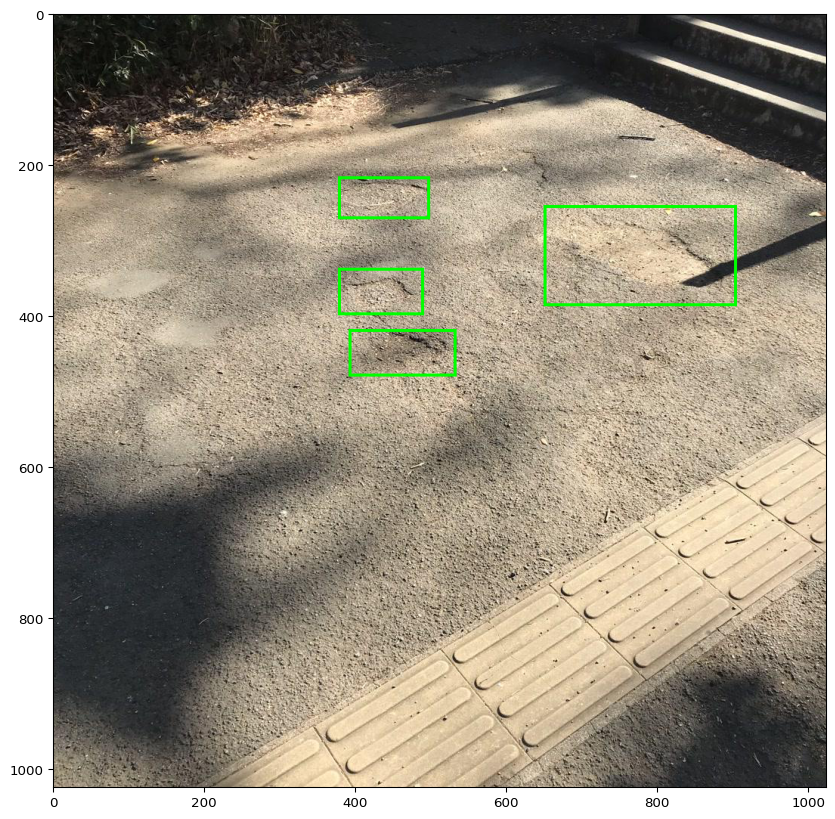

In [ ]:

# pass the array of bounding boxes coordinates to the imgaug library
image = imageio.imread('/content/data/Images/train_images/Japan_010845.jpg')
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
# display the image and draw bounding boxes
print('1024 x 1024 image: ')
ia.imshow(bbs.draw_on_image(image, size=4))


### Resize train Images

In [ ]:
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
   # print(bbs_array)
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs


In [ ]:
def resize_img(label_dataframe,height,width, image_path, aug_images_path, image_prefix):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','label', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = label_dataframe.groupby('filename')    
    
    for filename in label_dataframe['filename'].unique():
    #   Get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)
        
    #   The only difference between if and elif statements below is the use of height_resize and width_resize augmentors
    #   deffined previously.
        image = imageio.imread(image_path+filename)
        #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'label'], axis=1).values
        #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
        #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = resize(image=image, bounding_boxes=bbs)
        #   write augmented image to a file
        imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
        info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)        
        for index, _ in info_df.iterrows():
            info_df.at[index, 'width'] = image_aug.shape[1]
            info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
        info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
        bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
        aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
        aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])
            
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [ ]:

# to resize the images we create two augmenters
# one is used when the image height is more than 600px and the other when the width is more than 600px

height = 640
width = 640

resize = iaa.Sequential([ 
    iaa.Resize({"height": height, "width": width})
])



# apply resizing augmentation to our images and write the updated images and bounding boxes annotations to the DataFrame 
# we will not apply prefix to our files and will overwrite images in the same directory
image_path='/content/data/Images/train_images/'
aug_images_path = '/content/data/Images/train_images/'

resized_train_images_df = resize_img(label_dataframe=train_label_df,height = height,width=width,
                                  image_path = image_path,aug_images_path=aug_images_path, image_prefix = '')

In [ ]:
resized_train_images_df.head(10)

,filename,width,height,label,xmin,ymin,xmax,ymax
0,India_002925.jpg,640,640,D00,20.444447,303.111115,202.666656,568.000000
1,India_002925.jpg,640,640,D00,504.888885,406.222229,593.777771,549.333374
2,India_002925.jpg,640,640,D40,576.000000,448.000000,634.666687,512.000000
3,Japan_002084.jpg,640,640,D20,450.133331,441.600006,636.799988,600.533325
4,Japan_002084.jpg,640,640,D10,414.933319,390.400024,469.333344,406.399994
5,India_008395.jpg,640,640,D40,434.666687,401.777771,492.444458,434.666687
6,India_008395.jpg,640,640,D40,550.222229,464.888885,640.000000,515.555542
7,India_008395.jpg,640,640,D20,312.000000,452.444458,516.444458,556.444458
8,Japan_006397.jpg,640,640,D43,5.333333,470.400024,640.000000,636.799988
9,India_005365.jpg,640,640,D00,136.888885,429.333344,187.555557,471.111115


In [ ]:
resized_train_images_df.isnull().sum()

filename    0
width       0
height      0
label       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

### Resize test Images

In [ ]:

# to resize the images we create two augmenters
# one is used when the image height is more than 600px and the other when the width is more than 600px

height = 640
width = 640

resize = iaa.Sequential([ 
    iaa.Resize({"height": height, "width": width})
])



# apply resizing augmentation to our images and write the updated images and bounding boxes annotations to the DataFrame 
# we will not apply prefix to our files and will overwrite images in the same directory
image_path='/content/data/Images/test_images/'
aug_images_path = '/content/data/Images/test_images/'
#label_dataframe = test_label_df
resized_test_images_df = resize_img(label_dataframe=test_label_df,height = height,width=width,
                                  image_path = image_path,aug_images_path=aug_images_path, image_prefix = '')

In [ ]:
resized_test_images_df.head(10)

,filename,width,height,label,xmin,ymin,xmax,ymax
0,Japan_006013.jpg,640,640,D20,75.733330,485.333313,640.000000,640.000000
1,Japan_006013.jpg,640,640,D10,37.333332,410.666656,130.133331,452.266663
2,Japan_006013.jpg,640,640,D10,99.199997,406.399994,212.266678,429.866669
3,Japan_009051.jpg,640,640,D44,322.133331,389.333344,332.799988,432.000000
4,Japan_009051.jpg,640,640,D44,314.666687,467.200012,348.800018,636.799988
5,India_009132.jpg,640,640,D20,143.111115,438.222229,549.333374,549.333374
6,Japan_002321.jpg,640,640,D43,4.266667,381.866699,640.000000,599.466675
7,Japan_002321.jpg,640,640,D00,313.600006,344.533356,338.133301,425.600006
8,Japan_013132.jpg,640,640,D00,578.133301,293.333344,640.000000,358.399994
9,Japan_013132.jpg,640,640,D43,201.600006,87.466667,437.333344,122.666664


In [ ]:
resized_test_images_df.isnull().sum()

filename    0
width       0
height      0
label       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

640 x 640 image:


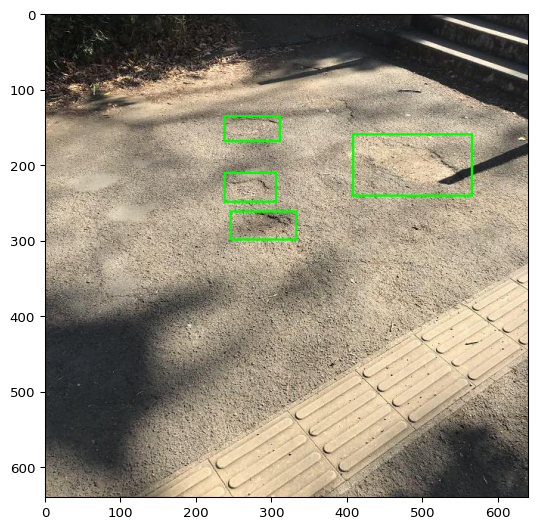

In [ ]:
# visualise the resized 'Japan_010845.jpg' image with bounding boxes
# to make sure our bounding boxes were resized correctly as well
grouped = resized_train_images_df.groupby('filename')
group_df = grouped.get_group('Japan_010845.jpg')
group_df = group_df.reset_index()
group_df = group_df.drop(['index'], axis=1)
bb_array = group_df.drop(['filename', 'width', 'height', 'label'], axis=1).values
image = imageio.imread('/content/data/Images/train_images/Japan_010845.jpg')
bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
print('640 x 640 image:')
ia.imshow(bbs.draw_on_image(image, size=3))




### Visualising Resized Test Images:

In [ ]:

#grouped_original = test_label_df.groupby('filename')
grouped_resized = resized_test_images_df.groupby('filename')

for filename in resized_test_images_df['filename'].unique()[0:20]:  
    fig, cell = plt.subplots(1, 1, figsize=(7,7))
  
    group_r_df = grouped_resized.get_group(filename)
    group_r_df = group_r_df.reset_index()
    group_r_df = group_r_df.drop(['index'], axis=1)
    bb_r_array = group_r_df.drop(['filename', 'width', 'height'], axis=1).values
    resized_img = imageio.imread('/content/data/Images/test_images/'+filename)
    img_array1 = np.asarray(resized_img)
    cell.imshow(img_array1)
    #bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)
    #print(bb_r_array)
    for box in bb_r_array:
      xmin = box[1]
      ymin = box[2]
      xmax = box[3]
      ymax = box[4]
     # color = colors[int(box[0])]
      label = '{}'.format(box[0])
      cell.set_title('Resized image 640x640',fontsize = 18)
      cell.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, linewidth=2))  
      cell.text(xmin, ymin, label, size='large', color='black', bbox={'alpha':0.5})

    
   
    
 

## Augmenting Train Images:

In [ ]:
!rm -rf  '/content/data/Images/augmented_image'

In [ ]:
!mkdir  '/content/data/Images/augmented_image'

In [ ]:
def image_aug(df, images_path, aug_images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','label', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
    #   read the image
        image = imageio.imread(images_path+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'label'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(aug_images_path+image_prefix+filename, image_aug)  
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [ ]:

# This setup of augmentation parameters will pick 3 of 8 given augmenters and apply them in random order
aug = iaa.SomeOf(3, [    
    iaa.Affine(scale=(0.6,1.2)),#zoom in or zoom out
    iaa.Affine(rotate=(-8, 8)),#rotation
    #iaa.Affine(translate_percent={"x": (-0.3, 0.3), "y": (-0.3, 0.3)}),
    iaa.LinearContrast((0.5,1.5),per_channel=True),#contrast
    iaa.Fliplr(0.4),#mirror image horizontally
    #iaa.Flipud(0.1),#mirror image vartically
    iaa.Multiply((0.5, 1.5)),#multipy pixels 
    iaa.GaussianBlur(sigma=(1.0, 3.0)),#blur image
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255)),#adding gausian noise
    iaa.Sharpen(alpha=(0.5), lightness=(0.75,1.5)) #sharpen images
])


# Apply augmentation to our images and save files into 'augmented_image/' folder with 'aug_' prefix.
# Write the updated images and bounding boxes annotations to the augmented_images_df dataframe.
input_image_path = '/content/data/Images/train_images/'   #image path
aug_image_path = '/content/data/Images/augmented_image/'   #path to store augmented images
aug_prefix = 'aug_'   #prefix to be add to identify augmented image (optional)
augmentor = aug   #callinf aug fuction which is define above
augmented_train_images_df = image_aug(resized_train_images_df,input_image_path,aug_image_path, aug_prefix, augmentor)

In [ ]:
augmented_train_images_df

,filename,width,height,label,xmin,ymin,xmax,ymax
0,aug_India_002925.jpg,640,640,D00,2.063132,302.103790,195.485550,583.273926
1,aug_India_002925.jpg,640,640,D00,516.283752,411.552582,610.636108,563.459961
2,aug_India_002925.jpg,640,640,D40,591.765686,455.898193,640.000000,523.831909
3,aug_Japan_002084.jpg,640,640,D20,2.200012,441.600006,188.866669,600.533325
4,aug_Japan_002084.jpg,640,640,D10,169.666656,390.400024,224.066681,406.399994
...,...,...,...,...,...,...,...,...
27692,aug_Czech_000905.jpg,640,640,D10,272.962128,481.325409,470.327423,518.942322
27693,aug_Japan_003113.jpg,640,640,D10,383.793671,544.382385,540.896545,580.111938
27694,aug_Japan_003113.jpg,640,640,D10,424.664703,472.992279,495.603943,488.138947
27695,aug_Japan_003113.jpg,640,640,D10,315.037811,434.142426,459.852753,461.499329


In [ ]:
augmented_train_images_df.isnull().sum()

filename     0
width        0
height       0
label        0
xmin        25
ymin        25
xmax        25
ymax        25
dtype: int64

Due to augmentation some boxes might be out of image plane so that boxes will shows ans NaN .So we will remove Nan's In from datafram.

In [ ]:
augmented_train_images_df=augmented_train_images_df.dropna()
augmented_train_images_df.isnull().sum()

filename    0
width       0
height      0
label       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [ ]:
'''
grouped_resized = resized_images_df.groupby('filename')
grouped_augmented = augmented_images_df.groupby('filename')

for filename in resized_images_df['filename'].unique()[0:20]:    
    
    group_r_df = grouped_resized.get_group(filename)
    group_r_df = group_r_df.reset_index()
    group_r_df = group_r_df.drop(['index'], axis=1)
    bb_r_array = group_r_df.drop(['filename', 'width', 'height', 'label'], axis=1).values
    resized_img = imageio.imread('/content/data/Images/train_images/'+filename)
    bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)
    
    print(filename)
    group_a_df = grouped_augmented.get_group('aug_'+filename)
    group_a_df = group_a_df.reset_index()
    group_a_df = group_a_df.drop(['index'], axis=1)
    bb_a_array = group_a_df.drop(['filename', 'width', 'height', 'label'], axis=1).values
    augmented_img = imageio.imread('/content/data/Images/augmented_image/'+'aug_'+filename)
    bbs_a = BoundingBoxesOnImage.from_xyxy_array(bb_a_array, shape=augmented_img.shape)
    
    ia.imshow(np.hstack([
            bbs_r.draw_on_image(resized_img, size=2),
            bbs_a.draw_on_image(augmented_img, size=2)
            ]))
'''

## Visualising Augmented vs. Resized Train Images

In [ ]:

grouped_resized = resized_train_images_df.groupby('filename')
grouped_augmented = augmented_train_images_df.groupby('filename')

for filename in resized_train_images_df['filename'].unique()[0:20]:  
    fig, cell = plt.subplots(1, 2, figsize=(20,16))
  
    group_r_df = grouped_resized.get_group(filename)
    group_r_df = group_r_df.reset_index()
    group_r_df = group_r_df.drop(['index'], axis=1)
    bb_r_array = group_r_df.drop(['filename', 'width', 'height'], axis=1).values
    resized_img = imageio.imread('/content/data/Images/train_images/'+filename)
    img_array1 = np.asarray(resized_img)
    cell[0].imshow(img_array1)
    #bbs_r = BoundingBoxesOnImage.from_xyxy_array(bb_r_array, shape=resized_img.shape)
    #print(bb_r_array)
    for box in bb_r_array:
      xmin = box[1]
      ymin = box[2]
      xmax = box[3]
      ymax = box[4]
     # color = colors[int(box[0])]
      label = '{}'.format(box[0])
      cell[0].set_title('Orignal Image',fontsize = 18)
      cell[0].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, linewidth=2))  
      cell[0].text(xmin, ymin, label, size='x-large', color='black', bbox={'alpha':0.5})

    
   
    group_a_df = grouped_augmented.get_group('aug_'+filename)
    group_a_df = group_a_df.reset_index()
    group_a_df = group_a_df.drop(['index'], axis=1)
    bb_a_array = group_a_df.drop(['filename', 'width', 'height',], axis=1).values
    augmented_img = imageio.imread('/content/data/Images/augmented_image/'+'aug_'+filename)
    img_array2 = np.asarray(augmented_img)
    cell[1].imshow(img_array2)
   # bbs_a = BoundingBoxesOnImage.from_xyxy_array(bb_a_array, shape=augmented_img.shape)
    for box in   bb_a_array :
      xmin = box[1]
      ymin = box[2]
      xmax = box[3]
      ymax = box[4]
      #color = colors[int(box[0])]
      label = '{}'.format(box[0])
      cell[1].set_title('Augmented Image',fontsize = 18)
      cell[1].add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, linewidth=2))  
      cell[1].text(xmin, ymin, label, size='x-large', color='black', bbox={'alpha':0.5})
    
 

In [ ]:
augmented_train_images_df.filename.values

array(['aug_India_002925.jpg', 'aug_India_002925.jpg',
       'aug_India_002925.jpg', ..., 'aug_Japan_003113.jpg',
       'aug_Japan_003113.jpg', 'aug_Japan_007829.jpg'], dtype=object)

In [ ]:
for fil in augmented_train_images_df.filename.values:
    shutil.copy( '/content/data/Images/augmented_image/'+ fil, "/content/data/Images/train_images/")



In [ ]:
!rm -rf /content/data/Images/augmented_image

In [ ]:
file_list = [filename for filename in os.listdir('/content/data/Images/train_images')]
print('Total train images in train_images folder  : ',len(file_list)) 

Total train images in train_images folder  :  11654


In [ ]:
#combining resized train images dataframe and augmented dataframes together.
org_aug_train_combine = pd.concat([resized_train_images_df,augmented_train_images_df])
org_aug_train_combine.shape

(55373, 8)

Counter({'D20': 6684, 'D00': 5242, 'D40': 4523, 'D44': 3983, 'D10': 3545, 'D50': 2896, 'D43': 641, 'D01': 149, 'D11': 38})


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution of classes')

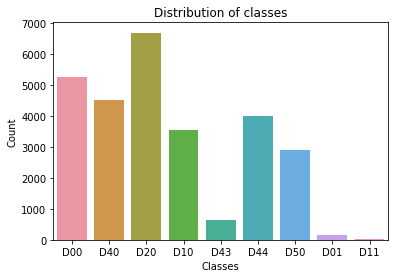

In [ ]:
count_dict = collections.Counter(train_label_df.label)
#classes = list(count_dict.keys()) 
print(count_dict)
count = []
for label in classes:
  count.append(count_dict[label])

sns.set_palette("winter", 8)
sns.barplot(classes,count)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of classes')

In [ ]:
org_aug_train_combine.isnull().sum()

filename    0
width       0
height      0
label       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [ ]:
#Convert dataframe to csv files
resized_train_images_df.to_csv('/content/data/label_csv/train_resized_label.csv',index = False)
resized_test_images_df.to_csv('/content/data/label_csv/test_resized_label.csv',index = False)
augmented_train_images_df.to_csv('/content/data/label_csv/aug_train_label.csv',index = False)
org_aug_train_combine.to_csv('/content/data/label_csv/orignal_plus_aug_combine.csv',index=False)

In [ ]:
file_list = [filename for filename in os.listdir('/content/data/Images/train_images')]
print('Total train images in train_images folder  : ',len(file_list)) 

file_list = [filename for filename in os.listdir('/content/data/Images/test_images')]
print('Total train images in test_images folder  : ',len(file_list)) 

Total train images in train_images folder  :  23306
Total train images in test_images folder  :  2914


In [ ]:
!zip -r /content/data.zip /content/data



In [ ]:
shutil.copy('/content/generate_tfrecord.py' , '/content/data')

'/content/data/generate_tfrecord.py'

In [ ]:
!rm -r /content/drive/MyDrive/object_detection/data

rm: cannot remove '/content/drive/MyDrive/object_detection/data': No such file or directory


In [ ]:
!cp -avr /content/data /content/drive/MyDrive/object_detection

In [ ]:
import os
file_list = [filename for filename in os.listdir('/content/drive/MyDrive/object_detection/data/Images/train_images')]
print('Total train images in train_images folder  : ',len(file_list)) 

file_list = [filename for filename in os.listdir('/content/drive/MyDrive/object_detection/data/Images/test_images')]
print('Total train images in test_images folder  : ',len(file_list))

file_list = [filename for filename in os.listdir('/content/drive/MyDrive/object_detection/data/Images/augmented_image')]
print('Total train images in augmented_images folder  : ',len(file_list))

Total train images in train_images folder  :  11654
Total train images in test_images folder  :  2914
Total train images in augmented_images folder  :  11654


Here we zipped folder into drive for training SSD_mobilnet and Faster_RCNN.